<a href="https://colab.research.google.com/github/feras-nahhal/insurance-claims-analysis/blob/main/insurance_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


# Import packages
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
set_config(transform_output='pandas')


# file path from google drive
path= '/content/drive/MyDrive/AXSOSACADEMY/03-DataEnrichment/Week09/Data/Car_Insurance_Claim.csv'

df = pd.read_csv(path)
df=df.set_index('ID')
df.info()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICL

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

1. What is the target?

2. What does one row represent? insurance customer "person"
3. How many features does the data have? 18 including the target "17 input features"
4. How many rows are in the dataset?  10,000
5. What opportunities exist for dimensionality reduction or feature selection with this dataset?
- Filter Methods (Correlation, Variance)
- Embedded Methods (Logistic Regression, Tree Importance)
- Wrapper Methods (Sequential Feature Selection)

6. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
- Many categorical columns to encode, class imbalance, sparse features after one-hot encoding

In [53]:
#Check for missing values. You should produce an output showing the number of missing values for each feature.
df.isna().sum()

,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,982
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0
MARRIED,0


In [54]:
#Check for and address any inconsistent values in object columns. (do not drop the entire feature)
# Saving list of column names for object_columns
object_columns = df.select_dtypes(include=['object']).columns
object_columns

# Obtain the value counts for all object columns
for column in object_columns:
  print(f"Value Counts for {column}")
  print(df[column].value_counts())
  print('========================')
  print('\n')


Value Counts for AGE
AGE
26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: count, dtype: int64


Value Counts for GENDER
GENDER
female    5010
male      4990
Name: count, dtype: int64


Value Counts for RACE
RACE
majority    9012
minority     988
Name: count, dtype: int64


Value Counts for DRIVING_EXPERIENCE
DRIVING_EXPERIENCE
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64


Value Counts for EDUCATION
EDUCATION
high school    4157
university     3928
none           1915
Name: count, dtype: int64


Value Counts for INCOME
INCOME
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64


Value Counts for VEHICLE_YEAR
VEHICLE_YEAR
before 2015    6967
after 2015     3033
Name: count, dtype: int64


Value Counts for VEHICLE_TYPE
VEHICLE_TYPE
sedan         9523
sports car     477
Name: count, dtype: int64




In [55]:
# Check for and address any impossible values in numeric columns.

# Saving list of column names for numeric_columns
numeric_columns = df.select_dtypes('number').columns
numeric_columns

# Obtain the describition for all numeric columns
for column in numeric_columns:
  print(f"describition for {column}")
  print(df[column].describe())
  print('========================')
  print('\n')

describition for CREDIT_SCORE
count    9018.000000
mean        0.515813
std         0.137688
min         0.053358
25%         0.417191
50%         0.525033
75%         0.618312
max         0.960819
Name: CREDIT_SCORE, dtype: float64


describition for VEHICLE_OWNERSHIP
count    10000.000000
mean         0.697000
std          0.459578
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: VEHICLE_OWNERSHIP, dtype: float64


describition for MARRIED
count    10000.000000
mean         0.498200
std          0.500022
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: MARRIED, dtype: float64


describition for CHILDREN
count    10000.000000
mean         0.688800
std          0.463008
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: CHILDREN, dtype: float64


describition for POSTAL_CODE
count    10000.

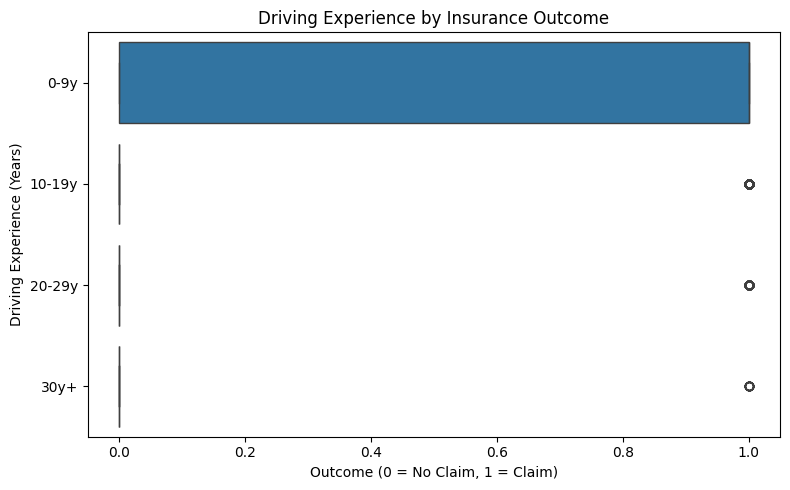

In [56]:
# Boxplot of Driving Experience by Outcome
plt.figure(figsize=(8, 5))
sns.boxplot(x='OUTCOME', y='DRIVING_EXPERIENCE', data=df)
plt.title('Driving Experience by Insurance Outcome')
plt.xlabel('Outcome (0 = No Claim, 1 = Claim)')
plt.ylabel('Driving Experience (Years)')
plt.tight_layout()
plt.show()

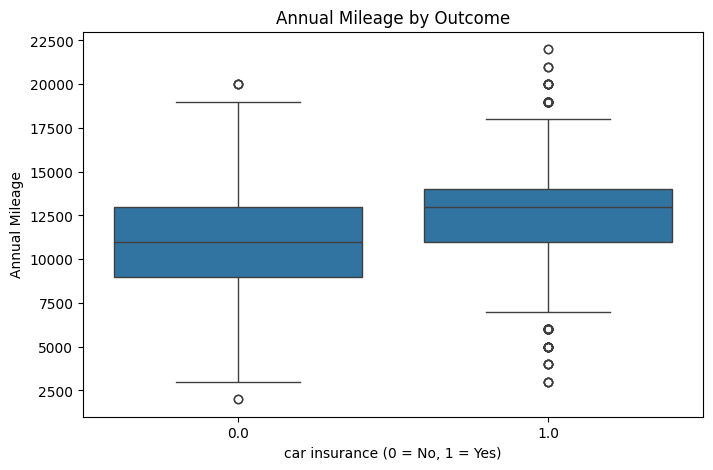

In [57]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='OUTCOME', y='ANNUAL_MILEAGE', data=df)
plt.title('Annual Mileage by Outcome')
plt.xlabel('car insurance (0 = No, 1 = Yes)')
plt.ylabel('Annual Mileage')
plt.show()


In [58]:
# Define target
target_col = 'OUTCOME'

# Make list of columns to drop. In this case just the id column for now
drop_cols = ['POSTAL_CODE']

# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col,*drop_cols]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)

In [59]:
#PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = X.select_dtypes('number').columns
print("Numeric Columns:", num_cols)

# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)

# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

Numeric Columns: Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')


In [60]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = ['GENDER',"RACE","VEHICLE_TYPE"]
print("OneHotEncoder Columns:", ohe_cols)

# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)

# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: ['GENDER', 'RACE', 'VEHICLE_TYPE']


In [61]:
# Prepare ordinal pipeline
# Save list of column names
ord_cols = ['AGE','DRIVING_EXPERIENCE','EDUCATION','VEHICLE_YEAR']
print("ordinal Columns:", ord_cols)

# Specifying the order of categories in quality/condition columns
AGE_order = ['26-39','40-64','16-25','65+']
DRIVING_EXPERIENCE_order = ["0-9y","10-19y","20-29y","30y+"]
EDUCATION_order = ['high school','university','none']
VEHICLE_YEAR_order = ["before 2015","after 2015"]

# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [AGE_order, DRIVING_EXPERIENCE_order,EDUCATION_order,VEHICLE_YEAR_order ]

# Ordinal Encoder
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

# make a pipeline
ord_pipe = make_pipeline( ord_encoder)
ord_tuple = ('ordinal', ord_pipe, ord_cols)

ordinal Columns: ['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'VEHICLE_YEAR']


In [62]:
# Define a column transformer
preprocessor  = ColumnTransformer([num_tuple, ohe_tuple,ord_tuple],
                                  verbose_feature_names_out=False)

In [63]:
# Instantiate default random forest model
rf = RandomForestClassifier(random_state=42)
# Model Pipeline
rf_pipe_Classifier = make_pipeline(preprocessor, rf)

In [64]:
# Fit the model pipeline on the training data only
rf_pipe_Classifier.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeli...
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['26-39',
                                                                                               '40-64',
                                                                                               '16-25',
                                                                                               '65+'],
                                                                                              ['0-9y',
                                                                                               '10-19y',
                                                                                               '20-29y',
                                                                                               '30y+'],
                                                                                              ['high '
                                                                                               'school',
                                                                                               'university',
                                                                                               'none'],
                                                                                              ['before '
                                                                                               '2015',
                                                                                               'after '
                                                                                               '2015']]))]),
                                                  ['AGE', 'DRIVING_EXPERIENCE',
                                                   'EDUCATION',
                                                   'VEHICLE_YEAR'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5119
         1.0       1.00      1.00      1.00      2381

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



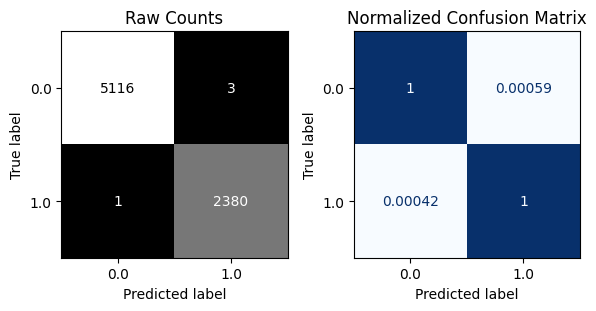


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1748
         1.0       0.75      0.66      0.70       752

    accuracy                           0.83      2500
   macro avg       0.81      0.78      0.79      2500
weighted avg       0.83      0.83      0.83      2500



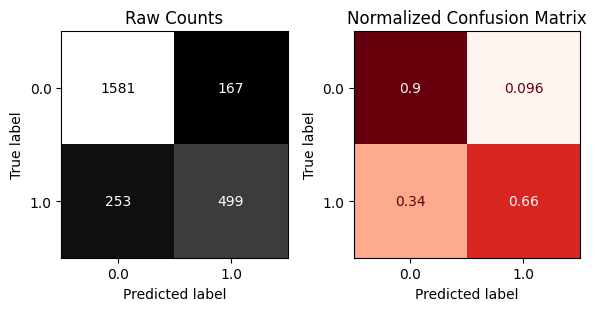

In [65]:
evaluate_classification(rf_pipe_Classifier, X_train, y_train, X_test, y_test)

In [66]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

In [67]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

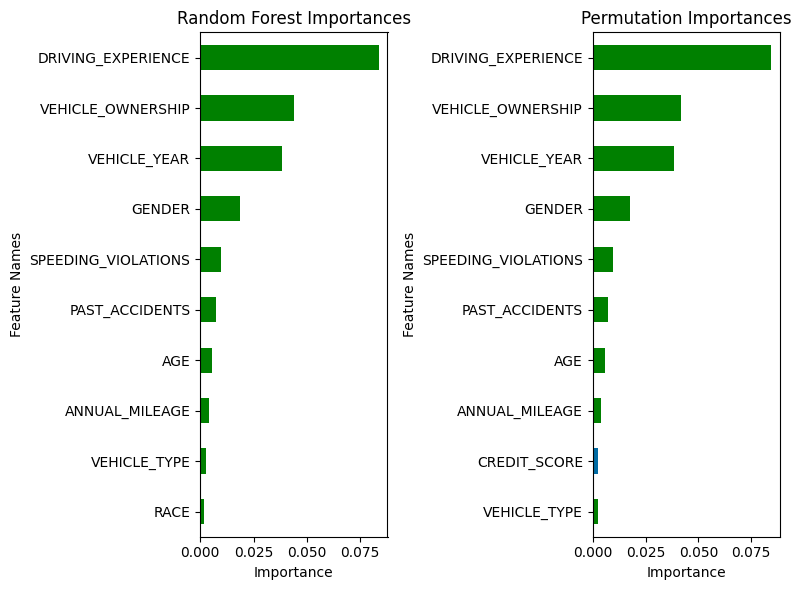

In [68]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Get permutation importance using the trained model and test data
r = permutation_importance(
    rf_pipe_Classifier, X_test, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)

# Create a Series from mean importances
permutation_importances = pd.Series(
    r['importances_mean'],
    index=X_test.columns,
    name='Permutation Importance'
).sort_values(ascending=False)

# Generate color dictionary for consistent coloring
colors_top10 = get_color_dict(importances, top_n=10)

# Create side-by-side plots
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))
n = 10  # Number of top features to show

plot_importance_color_ax(importances, top_n=n, ax=axes[0], color_dict=colors_top10)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1], color_dict=colors_top10)

# Set plot titles
axes[0].set(title='Random Forest Importances')
axes[1].set(title='Permutation Importances')

# Finalize layout
fig.tight_layout()
plt.show()


- Add your observations in a Markdown: Do these features make sense based on the business case?


from the permutation importance the top Key features is driving experience, vehicle year, and past accidents, and they make a lot of sense for real world application as newer car with good driving experience make the best predicting.

- Create Explanatory Visualizations for the most important features.
1. Driving Experience vs Insurance Claims
2. Vehicle Ownership vs Insurance Claims

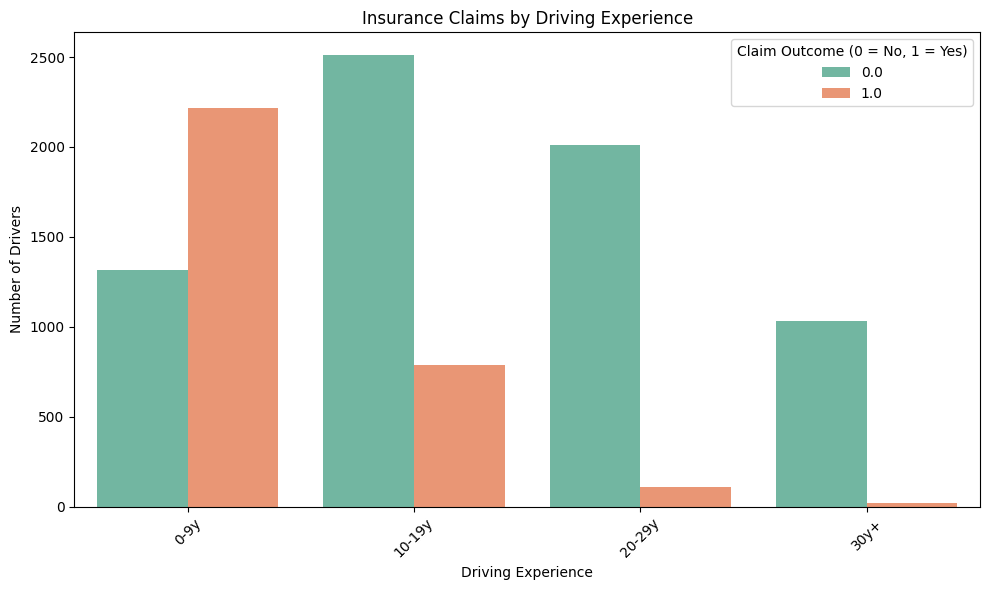

In [69]:
#Driving Experience vs Insurance Claims
plt.figure(figsize=(10,6))
sns.countplot(x='DRIVING_EXPERIENCE', hue='OUTCOME', data=df, palette='Set2')
plt.title('Insurance Claims by Driving Experience')
plt.xlabel('Driving Experience')
plt.ylabel('Number of Drivers')
plt.legend(title='Claim Outcome (0 = No, 1 = Yes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


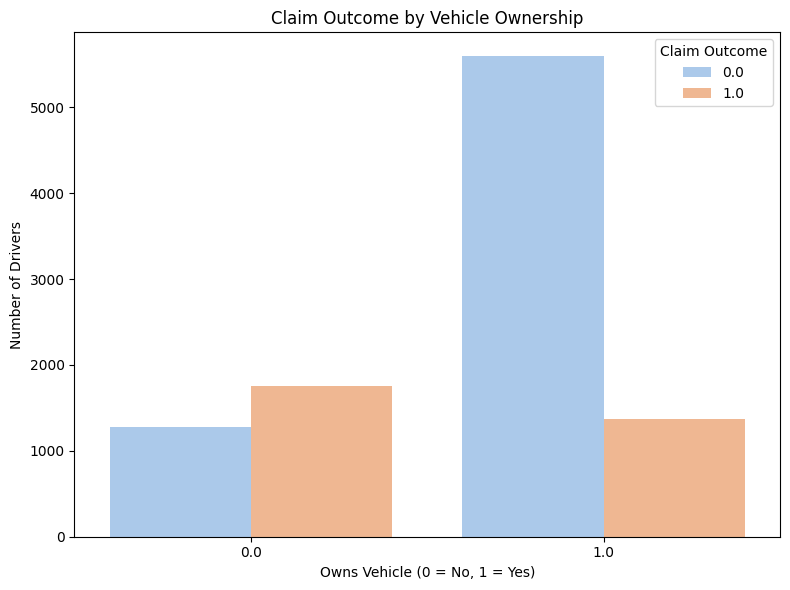

In [70]:
#Vehicle Ownership vs Insurance Claims
plt.figure(figsize=(8,6))
sns.countplot(x='VEHICLE_OWNERSHIP', hue='OUTCOME', data=df, palette='pastel')
plt.title('Claim Outcome by Vehicle Ownership')
plt.xlabel('Owns Vehicle (0 = No, 1 = Yes)')
plt.ylabel('Number of Drivers')
plt.legend(title='Claim Outcome')
plt.tight_layout()
plt.show()